# IGNITION PROGRAM, challenge data-science : recommandation VOD 

## Introduction 
Le but est de recommander des films à un client qui vient de venir voir Inferno. On pose quelques hypothèses : 
* On n'a pas d'informations sur le client. On part du principe qu'il a aimé Inferno pour fournir un service de type "Si vous avez aimé Inferno, vous allez aimer ..." 
* Sur 7 jours, j'ai choisi d'utiliser une librairie (Graphlab) qui permet d'explorer plusieurs types de modèles et d'avoir un output propre
* Le dataset utilisé pour entrainer les modèles est "MovieLens Latest Datasets" qui est une base qui contient une liste de films avec leur genres, une base de notations utilisateurs des films, ainsi qu'une base avec des tags affectés par les utilisateurs
* Les modèles sont optimisé avec la mesure precision-recall mais ce qui est intéressant est de juger par soi même de la cohérence des résultats de recommandations pour Inferno en particulier


In [3]:
import graphlab as gl
import pandas as pd 

# Model 0: similarité

On va d'abord partir sur le principe de conseiller des films qui ressemblent à Inferno (même genre, année proche)

In [8]:
movie=gl.load_sframe('movie_data')
movie_genres=gl.load_sframe('movie_genres')


In [82]:
Inferno=movie_genres[movie_genres["movieId"]==165101]
movie_genres=movie_genres[movie_genres['year'].astype(int)<2016]



In [83]:
movie_genres_dist=movie_genres
movieID=movie_genres["movieId"]
movie_genres['year']==movie_genres['year'].astype(int)
movie_genres_dist.remove_column("movieId")
Inferno_dist=Inferno.remove_column("movieId")


In [84]:

k=0
cos=[]
jac=[]
for mov in range(len(movieID)):
    cos.append(gl.distances.cosine(Inferno_dist[0],movie_genres_dist[mov]))
    jac.append(gl.distances.jaccard(Inferno_dist[0],movie_genres_dist[mov]))

In [85]:
Inferno_similarities=gl.SFrame({"movieId": movieID, "cosine":cos, "jaccard": jac})
Inferno_similarities=Inferno_similarities.sort("cosine")
Inferno_similarities["movieId"][:10]

dtype: int
Rows: 10
[128592L, 114007L, 130574L, 120278L, 160698L, 112866L, 139533L, 106508L, 108729L, 109472L]

In [86]:
movie.filter_by(Inferno_similarities["movieId"][:10],"movieId")

movieId,title,genres
106508,"Dyatlov Pass Incident,The (Devil's Pass) (2 ...",Mystery|Thriller
108729,Enemy (2013),Mystery|Thriller
109472,Grand Piano (2013),Mystery|Thriller
112866,"Strange Color Of YourBody's Tears, The ...",Mystery|Thriller
114007,Before I Go to Sleep(2014) ...,Mystery|Thriller
120278,Another Me (2013),Mystery|Thriller
128592,The Boy Next Door (2015),Mystery|Thriller
130574,Something Wicked (2014),Mystery|Thriller
139533,The Secret Village (2013),Mystery|Thriller
160698,Steel Cold Winter (2013),Mystery|Thriller


# Model 1: avec ratings

In [7]:
ratings=gl.load_sframe("ratings_long")

In [11]:
ratings.head()

userId,movieId,rating,timestamp
1,122,2.0,945544824
1,172,1.0,945544871
1,1221,5.0,945544788
1,1441,4.0,945544871
1,1609,3.0,945544824
1,1961,3.0,945544871
1,1972,1.0,945544871
2,441,2.0,1008942733
2,494,2.0,1008942733
2,1193,4.0,1008942667


In [30]:
movie=gl.load_sframe('movie_data')

In [31]:
movie.head()

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy ...
2,Jumanji (1995),Adventure|Children|Fantasy ...
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride PartII (1995) ...,Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action
10,GoldenEye (1995),Action|Adventure|Thriller


In [43]:
high_rated_data=ratings[ratings["rating"]>=4]#On veut que le test set ne contiennent que des ratings haut puisque c'est ceux que l'on veut trouver 

low_rated_data=ratings[ratings["rating"]<4]
training_data1, test_data= gl.recommender.util.random_split_by_user(ratings, 'userId','movieId', "rating")
train_data=training_data1.append(low_rated_data)

In [44]:
model=gl.ranking_factorization_recommender.create(train_data, user_id='userId', item_id='movieId', target="rating")

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 36622812 observations with 259137 users and 39443 items.

Data prepared in: 35.0064s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 4577851 / 36622812 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | Not Viable                               |

| 4       | 0.0651042         | 1.23322                                  |

| 5       | 0.0325521         | 1.27831                                  |

| 6       | 0.016276          | 1.38684                                  |

| 7       | 0.00813802        | 1.5949                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0651042         | 1.23322                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 2.20683           | 1.06091               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1m 9s        | 1.16397           | 0.924986              | 0.0651042   |

| 2       | 2m 20s       | 1.04477           | 0.884625              | 0.0651042   |

| 3       | 3m 21s       | 0.97015           | 0.859525              | 0.0651042   |

| 4       | 4m 30s       | 0.961563          | 0.850038              | 0.0651042   |

| 5       | 5m 38s       | 0.937815          | 0.839404              | 0.0651042   |

| 6       | 6m 43s       | 0.923565          | 0.832892              | 0.0651042   |

| 7       | 7m 47s       | 0.909384          | 0.827052              | 0.0651042   |

| 8       | 8m 51s       | 0.898529          | 0.822715              | 0.0651042   |

| 9       | 9m 55s       | 0.888254          | 0.818964              | 0.0651042   |

| 10      | 10m 59s      | 0.880326          | 0.815404              | 0.0651042   |

| 11      | 12m 7s       | 0.872615          | 0.812042              | 0.0651042   |

| 12      | 13m 10s      | 0.865843          | 0.809107              | 0.0651042   |

| 13      | 14m 14s      | 0.859696          | 0.806292              | 0.0651042   |

| 14      | 15m 25s      | 0.853887          | 0.803869              | 0.0651042   |

| 15      | 16m 28s      | 0.84895           | 0.801499              | 0.0651042   |

| 16      | 17m 33s      | 0.844102          | 0.799452              | 0.0651042   |

| 17      | 18m 38s      | 0.840272          | 0.797666              | 0.0651042   |

| 18      | 19m 41s      | 0.836675          | 0.795974              | 0.0651042   |

| 19      | 20m 44s      | 0.833205          | 0.794342              | 0.0651042   |

| 20      | 21m 46s      | 0.830102          | 0.793035              | 0.0651042   |

| 21      | 22m 49s      | 0.827325          | 0.791774              | 0.0651042   |

| 22      | 23m 51s      | 0.824888          | 0.790669              | 0.0651042   |

| 23      | 24m 53s      | 0.822694          | 0.78978               | 0.0651042   |

| 24      | 25m 54s      | 0.821229          | 0.789171              | 0.0651042   |

| 25      | 26m 57s      | 0.820116          | 0.789078              | 0.0651042   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.931802

Final training RMSE: 0.858204

In [47]:
ID=movie[movie["title"]=="Inferno (2016)"]["movieId"]
closest=model.get_similar_items(ID, k=10)
closest["title"]=movie.filter_by(closest["similar"], "movieId")["title"]
closest

movieId,similar,score,rank,title
165101,135530,0.827987194061,1,Thrive (2011)
165101,131920,0.827319741249,2,"Fork in the Road, A(2010) ..."
165101,117543,0.819986701012,3,Comme un chef (2012)
165101,146307,0.818163692951,4,LOL (Laughing Out Loud)(2008) ...
165101,94679,0.816526710987,5,The Road Within (2014)
165101,139857,0.814173877239,6,Just Before I Go (2014)
165101,133545,0.811919391155,7,Criminal (2016)
165101,146688,0.81147813797,8,Colonia (2016)
165101,99800,0.810921907425,9,The Hallow (2015)
165101,100068,0.808490991592,10,Solace (2015)


C'est déjà pas trop mal ! 
Thrive est un documentaire sur les illuminatis 
Fork in the road est un navet a suspense 
Comme un chef, hors sujet comédie française sur la cuisine 
LOL comédie, romance française 
The Road within, Comédie dramatique 
Just Before I GO, Comédie dramatique 
Criminal, Action crime drama 
COlonia, Drama romance thriller 
The Hallow, Horreur 
SOlace, Crime, Drame Mystere

Il y a un peu des intrus, mais il faut savoir que la recommandation est uniquement faite sur la notation.
Apparemment certaines personnes doivent avoir des goûts assez variés ce qui permet de faire remonter certains films dont on ne voudrait à priori pas .
On peut essayer d'améliorer le modèle en utilisant en plus l'année de sortie ainsi que les genres 


# Modèle 2 : Adding side features 

## Creating a year column

In [32]:
import re

yrs=[]
patt=re.compile("(\d{4})")
for title in movie["title"]:
    if patt.search(title):
        yrs.append(patt.search(title).group())
    else:
        yrs.append('1000') #Si on ne trouve pas de date on met 1000
        
    
movie["year"]=yrs
movie

movieId,title,genres,year
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy ...,1995
2,Jumanji (1995),Adventure|Children|Fantasy ...,1995
3,Grumpier Old Men (1995),Comedy|Romance,1995
4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
5,Father of the Bride PartII (1995) ...,Comedy,1995
6,Heat (1995),Action|Crime|Thriller,1995
7,Sabrina (1995),Comedy|Romance,1995
8,Tom and Huck (1995),Adventure|Children,1995
9,Sudden Death (1995),Action,1995
10,GoldenEye (1995),Action|Adventure|Thriller,1995


## Creation des colonnes "genres"

In [9]:
all_tags=[]
for tags in movie["genres"]:
    a=tags.split("|")
    all_tags.extend(a)
all_tags=list(set(all_tags))


In [10]:
all_tags

['Mystery',
 'Drama',
 'Western',
 'Sci-Fi',
 'Horror',
 'Film-Noir',
 'Crime',
 'Romance',
 'Fantasy',
 'Musical',
 'Animation',
 'War',
 'Adventure',
 'Action',
 '(no genres listed)',
 'Comedy',
 'Documentary',
 'Children',
 'Thriller',
 'IMAX']

In [11]:
from time import time 

g=pd.DataFrame()
for genre in all_tags:
    g[genre]=[1 if genre in movie['genres'][i] else 0 for i in range(len(movie["genres"]))]

genres=gl.SFrame(g)
genres.save("genres_ratings_long")

-6721.49300003


In [33]:
genres=gl.load_sframe("genres_ratings_long")

In [34]:
genres.add_column(movie["movieId"])#On ajoute l'Id pour le join
movie_yr=movie.remove_columns(["genres", "title"])#On enleve les features qu'on ne veut pas
movie_genres=movie_yr.join(genres, on={"movieId":"X21"}, how="outer")
movie_genres.save("movie_genres")# On sauve sous SFrame pour charger plus vite

gl.load_sframe("movie_genres")

movieId,year,Mystery,Drama,Western,Sci-Fi,Horror,Film-Noir,Crime,Romance,Fantasy,Musical,Animation
1,1995,0,0,0,0,0,0,0,0,1,0,1
2,1995,0,0,0,0,0,0,0,0,1,0,0
3,1995,0,0,0,0,0,0,0,1,0,0,0
4,1995,0,1,0,0,0,0,0,1,0,0,0
5,1995,0,0,0,0,0,0,0,0,0,0,0
6,1995,0,0,0,0,0,0,1,0,0,0,0
7,1995,0,0,0,0,0,0,0,1,0,0,0
8,1995,0,0,0,0,0,0,0,0,0,0,0
9,1995,0,0,0,0,0,0,0,0,0,0,0
10,1995,0,0,0,0,0,0,0,0,0,0,0


movieId,year
1,1995
2,1995
3,1995
4,1995
5,1995
6,1995
7,1995
8,1995
9,1995
10,1995


## Lancement du modèle 

In [ ]:
movie=gl.load_sframe("movie_data/")

In [9]:
high_rated_data=ratings[ratings["rating"]>=4]#On veut que le test set ne contiennent que des ratings haut puisque c'est ceux que l'on veut trouver 

low_rated_data=ratings[ratings["rating"]<4]
training_data1, test_data= gl.recommender.util.random_split_by_user(high_rated_data, user_id='userId',item_id='movieId')
train_data=training_data1.append(low_rated_data)

In [10]:
test_data


userId,movieId,rating,timestamp
702,2406,5.0,992314882
1014,541,5.0,1286458022
1014,908,4.0,1286458930
1014,1193,4.0,1286458452
1014,1200,4.0,1286458358
1014,1203,5.0,1286458355
1014,1217,4.5,1286458938
1014,1225,5.0,1286458986
1014,1252,4.5,1286458809
1014,1258,5.0,1286458479


In [185]:

model=gl.ranking_factorization_recommender.create(train_data, user_id='userId', item_id='movieId', item_data=movie_genres, target="rating")

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 24404096 observations with 259137 users and 40110 items.

Data prepared in: 48.5947s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 3050512 / 24404096 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 2.08333           | Not Viable                               |

| 1       | 0.520833          | 0.876113                                 |

| 2       | 0.260417          | Not Viable                               |

| 3       | 0.0651042         | 0.701572                                 |

| 4       | 0.0325521         | 0.940015                                 |

| 5       | 0.016276          | 1.09485                                  |

| 6       | 0.00813802        | 1.33462                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0651042         | 0.701572                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 501us        | 2.22082           | 1.06418               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 3m 40s       | 1.03491           | 0.900057              | 0.0651042   |

| 2       | 7m 2s        | 0.870514          | 0.824129              | 0.0651042   |

| 3       | 10m 22s      | 0.849665          | 0.812242              | 0.0651042   |

| 4       | 13m 35s      | 1.42021           | 1.05092               | 0.0651042   |

| 5       | 16m 46s      | 0.906205          | 0.847748              | 0.0651042   |

| 6       | 19m 49s      | 0.816306          | 0.798376              | 0.0651042   |

| 7       | 22m 57s      | 0.78826           | 0.783466              | 0.0651042   |

| 8       | 26m 7s       | 0.772831          | 0.775039              | 0.0651042   |

| 9       | 29m 5s       | 0.762734          | 0.769487              | 0.0651042   |

| 10      | 32m 13s      | 0.754717          | 0.765131              | 0.0651042   |

| 11      | 35m 12s      | 0.748601          | 0.761793              | 0.0651042   |

| 12      | 38m 27s      | 0.74334           | 0.758902              | 0.0651042   |

| 13      | 41m 35s      | 0.738978          | 0.756503              | 0.0651042   |

| 14      | 44m 44s      | 0.734999          | 0.754312              | 0.0651042   |

| 15      | 47m 54s      | 0.731556          | 0.752435              | 0.0651042   |

| 16      | 51m 4s       | 0.728608          | 0.750772              | 0.0651042   |

| 17      | 54m 15s      | 0.725886          | 0.749294              | 0.0651042   |

| 18      | 57m 30s      | 0.723252          | 0.74781               | 0.0651042   |

| 19      | 1h 0m        | 0.720848          | 0.746506              | 0.0651042   |

| 20      | 1h 3m        | 0.718924          | 0.745408              | 0.0651042   |

| 21      | 1h 7m        | 0.71683           | 0.744194              | 0.0651042   |

| 22      | 1h 10m       | 0.71505           | 0.74324               | 0.0651042   |

| 23      | 1h 13m       | 0.713091          | 0.742155              | 0.0651042   |

| 24      | 1h 16m       | 0.711618          | 0.741251              | 0.0651042   |

| 25      | 1h 19m       | 0.709944          | 0.740376              | 0.0651042   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.704768

Final training RMSE: 0.734373

In [ ]:
eval2=model.views.eval2

In [186]:
ID=movie[movie["title"]=="Inferno (2016)"]["movieId"]
closest=model.get_similar_items(ID, k=10)
closest["title"]=movie.filter_by(closest["similar"], "movieId")["title"]
closest

movieId,similar,score,rank,title
165101,118248,0.717472910881,1,Malice N Wonderland(2010) ...
165101,134117,0.699403226376,2,Megan Is Missing (2011)
165101,157671,0.696072280407,3,Vares: The Path of theRighteous Men (Vares - ...
165101,162668,0.673066854477,4,Open Windows (2014)
165101,114758,0.672721624374,5,Mercy (2014)
165101,104064,0.660680651665,6,Dying of the Light (2014)
165101,78974,0.657009661198,7,San Andreas Quake (2015)
165101,136188,0.650209903717,8,Hooking Up (2009)
165101,87909,0.645264387131,9,Manhattan Night (2016)
165101,115871,0.641859769821,10,Ki and Ka (2016)


In [190]:
model.save("model_year_genres_2")##Ca a mis longtemps à tourner donc on le garde de côté !


In [38]:
model_yr_gr=gl.load_model("model_year_genres_2/")
view2=model_yr_gr.views.explore(item_data=movie, item_name_column="title")
view2.show()
eval2=model_yr_gr.views.evaluate(validation_set=test_data)

In [39]:
eval2.show()

View object

URI: 		http://localhost:32212/view/cb8a3a4e-bf2e-434d-959f-d0e49c8c4bc7
HTML: 		
<gl-recommender-evaluate
    uri="http://localhost:32212/view/e0b159a0-068b-4ce8-a165-50b586dd641b"
    api_key=""
/>
        

# Modèle 3 : sans 2016 et en pénalisant les films non notés

In [17]:
genres=gl.load_sframe("movie_genres")
print(genres.shape)
genres_no_2016=genres[genres["year"]!="2016"]
genres_no_2016=genres_no_2016.append(genres[genres["movieId"]==165101])
print(genres_no_2016).shape ## on supprime environ 750 films !


(40110, 22)
(39384, 22)


In [136]:
ratings=gl.load_sframe("ratings_long")
print(ratings.shape)
ratings_no_2016=ratings.filter_by(genres_no_2016["movieId"], "movieId")

ratings_no_2016=ratings_no_2016.append(ratings[ratings["movieId"]==165101])
print(ratings_no_2016.shape)
ratings_no_2016.save("ratings_no_2016")

(24404096, 4)
(24370662, 4)


In [19]:
ratings_no_2016=gl.load_sframe("ratings_no_2016")


In [20]:
high_rated_data=ratings_no_2016[ratings_no_2016["rating"]>=4]#On veut que le test set ne contiennent que des ratings haut puisque c'est ceux que l'on veut trouver 

low_rated_data=ratings_no_2016[ratings_no_2016["rating"]<4]
training_data1, test_data= gl.recommender.util.random_split_by_user(high_rated_data, 'userId','movieId')
train_data=training_data1.append(low_rated_data)

Le fichier rating ne contenait environ 33000 reviews de 2016

In [187]:

model_reg=gl.ranking_factorization_recommender.create(train_data, user_id='userId', 
                                                  item_id='movieId', item_data=genres_no_2016, 
                                                  target="rating",
                                                  ranking_regularization=0.1, unobserved_rating_value=2) 
#On met une mauvaise note aux paires movie-user inexistantes 

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 24370662 observations with 259110 users and 39384 items.

Data prepared in: 23.3286s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.01     |

| unobserved_rating_value        | Ranking Target Rating for Unobserved Interacti...| 2        |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 3046332 / 24370662 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 2.08333           | Not Viable                               |

| 1       | 0.520833          | Not Viable                               |

| 2       | 0.130208          | 0.428971                                 |

| 3       | 0.0651042         | 0.379706                                 |

| 4       | 0.0325521         | 0.579939                                 |

| 5       | 0.016276          | No Decrease (1.24288 >= 1.15501)         |

| 6       | 0.00406901        | 0.856796                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0651042         | 0.379706                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.15564           | 1.0641                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 3m 53s       | 0.797979          | 0.882612              | 0.0651042   |

| 2       | 7m 52s       | 0.674231          | 0.811094              | 0.0651042   |

| 3       | 11m 39s      | 0.627609          | 0.782597              | 0.0651042   |

| 4       | 15m 25s      | 0.605366          | 0.768591              | 0.0651042   |

| 5       | 19m 13s      | 0.59051           | 0.759064              | 0.0651042   |

| 6       | 23m 1s       | 0.579313          | 0.751756              | 0.0651042   |

| 7       | 26m 47s      | 0.570198          | 0.745733              | 0.0651042   |

| 8       | 30m 34s      | 0.562584          | 0.740668              | 0.0651042   |

| 9       | 34m 18s      | 0.555974          | 0.73623               | 0.0651042   |

| 10      | 38m 3s       | 0.550156          | 0.732298              | 0.0651042   |

| 11      | 41m 50s      | 0.544943          | 0.728751              | 0.0651042   |

| 12      | 45m 36s      | 0.540209          | 0.725513              | 0.0651042   |

| 13      | 49m 25s      | 0.535858          | 0.722523              | 0.0651042   |

| 14      | 53m 11s      | 0.531884          | 0.71979               | 0.0651042   |

| 15      | 56m 58s      | 0.528204          | 0.717241              | 0.0651042   |

| 16      | 1h 0m        | 0.524787          | 0.714864              | 0.0651042   |

| 17      | 1h 4m        | 0.521617          | 0.712647              | 0.0651042   |

| 18      | 1h 8m        | 0.518667          | 0.710571              | 0.0651042   |

| 19      | 1h 12m       | 0.515931          | 0.708637              | 0.0651042   |

| 20      | 1h 15m       | 0.513391          | 0.706828              | 0.0651042   |

| 21      | 1h 19m       | 0.510994          | 0.705132              | 0.0651042   |

| 22      | 1h 23m       | 0.508715          | 0.703517              | 0.0651042   |

| 23      | 1h 26m       | 0.506561          | 0.701981              | 0.0651042   |

| 24      | 1h 30m       | 0.504514          | 0.700525              | 0.0651042   |

| 25      | 1h 34m       | 0.502617          | 0.699166              | 0.0651042   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.49464

Final training RMSE: 0.693355

In [188]:
model_reg.save("model_regularized")

In [189]:
closest=model_reg.get_similar_items(ID, k=10)
closest["title"]=movie.filter_by(closest["similar"], "movieId")["title"]
closest

movieId,similar,score,rank,title
165101,61913,0.837050795555,1,"Concorde: Airport '79,The (1979) ..."
165101,146435,0.818489432335,2,Conflict (1945)
165101,111119,0.805155158043,3,Trial of the Road (Check-up on the Roads) ...
165101,62208,0.79459220171,4,Africa addio (1966)
165101,68645,0.794170975685,5,Sound of the Mountain(Thunder of the Mount ...
165101,107778,0.793960571289,6,Man in the Middle (1963)
165101,109981,0.782868802547,7,Inn of Evil (Inochi bôni furô) (1971) ...
165101,34193,0.781925261021,8,Such Good Friends (1971)
165101,2536,0.781865179539,9,Man in the Wilderness(1971) ...
165101,45899,0.77873301506,10,The Hellstrom Chronicle(1971) ...


In [24]:
model_reg=gl.load_model("model_regularized")
view=model_reg.views.explore(item_data=movie, item_name_column="title")
view.show()
model_reg.evaluate_rmse()

TypeError: evaluate_rmse() takes exactly 3 arguments (1 given)

# Modèle 4 : filtrage des films trop originaux

On va essayer d'enlever les films trop étranges (dans le 2ème modèle notre plus proche était un court de snoop dogg, et dans le 3ème le film le plus réçent date de 1979 ....)

In [42]:
ratings=gl.load_sframe("ratings_no_2016")
ratings

userId,movieId,rating,timestamp
1,122,2.0,945544824
1,172,1.0,945544871
1,1221,5.0,945544788
1,1441,4.0,945544871
1,1609,3.0,945544824
1,1961,3.0,945544871
1,1972,1.0,945544871
2,441,2.0,1008942733
2,494,2.0,1008942733
2,1193,4.0,1008942667


In [43]:
#1. Compter le nb de rating par film 
import graphlab.aggregate as agg
ratings_counts=ratings.groupby(key_columns="movieId", operations={"ratings_count": agg.COUNT()})
ratings_counts

movieId,ratings_count
7899,158
144280,8
101076,608
27112,48
5288,566
103306,497
115341,2
88069,50
130466,28
61406,242


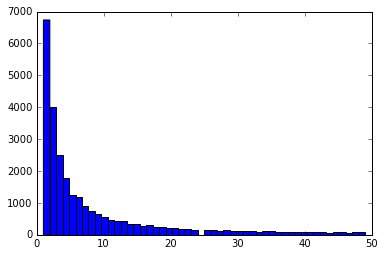

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(ratings_counts[ratings_counts["ratings_count"]<50]["ratings_count"], bins=50, )
plt.show()

on peut voir qu'il y a un certain nombre de films qui n'ont que très peu de ratings . On va arbitrairement enlever ceux qui ont moins de 10 ratings

In [45]:
ratings_counts=ratings_counts[ratings_counts["ratings_count"]>9]
ratings_counts.shape

(18986, 2)

In [46]:
movie_genres=gl.load_sframe("movie_genres/")
movie_genres

movieId,year,Mystery,Drama,Western,Sci-Fi,Horror,Film-Noir,Crime,Romance,Fantasy,Musical,Animation
1,1995,0,0,0,0,0,0,0,0,1,0,1
2,1995,0,0,0,0,0,0,0,0,1,0,0
3,1995,0,0,0,0,0,0,0,1,0,0,0
4,1995,0,1,0,0,0,0,0,1,0,0,0
5,1995,0,0,0,0,0,0,0,0,0,0,0
6,1995,0,0,0,0,0,0,1,0,0,0,0
7,1995,0,0,0,0,0,0,0,1,0,0,0
8,1995,0,0,0,0,0,0,0,0,0,0,0
9,1995,0,0,0,0,0,0,0,0,0,0,0
10,1995,0,0,0,0,0,0,0,0,0,0,0


Ca enlève quasiment la moitié des films . On va regarder maintenant les années de sortie 

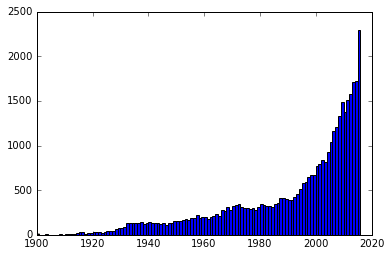

In [47]:
movie_genres=gl.load_sframe("movie_genres")

plt.hist(movie_genres['year'].astype(int).dropna(), range=[1900, 2016] ,bins=116)
plt.show()

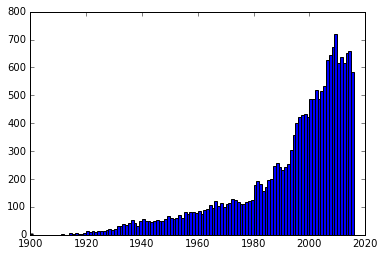

In [48]:
movie_genres=movie_genres.filter_by(ratings_counts["movieId"], "movieId")

plt.hist(movie_genres['year'].astype(int).dropna(), range=[1900, 2016] ,bins=116)
plt.show()


On a viré pas mal de films récents qui n'ont pas encore été notés apparement.

In [49]:
movie_genres_filter=movie_genres[movie_genres["year"].astype(int)<2016].append(movie_genres[movie_genres["movieId"]==165101])
ratings_filter=ratings.filter_by(movie_genres["movieId"],"movieId")

In [6]:
movie_genres_filter.save("movie_genres_filter")
ratings_filter.save("ratings_filter")


NameError: name 'movie_genres_filter' is not defined

In [4]:
movie_genres_filter=gl.load_sframe("movie_genres_filter/")
ratings_filter=gl.load_sframe("ratings_filter/")

This non-commercial license of GraphLab Create for academic use is assigned to loulouserr@gmail.com and will expire on January 03, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\loulo\AppData\Local\Temp\graphlab_server_1479752750.log.0


In [3]:
movie_genres_filter=gl.load_sframe("movie_genres_filter/")
ratings_filter=gl.load_sframe("ratings_filter/")
high_rated_data=ratings_filter[ratings_filter["rating"]>=4]#On veut que le test set ne contiennent que des ratings haut puisque c'est ceux que l'on veut trouver 

low_rated_data=ratings_filter[ratings_filter["rating"]<4]
training_data1, test_data= gl.recommender.util.random_split_by_user(high_rated_data, 'userId','movieId')
train_data=training_data1.append(low_rated_data)

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\loulo\AppData\Local\Temp\graphlab_server_1479748143.log.0


This non-commercial license of GraphLab Create for academic use is assigned to loulouserr@gmail.com and will expire on January 03, 2017.


In [ ]:


model_reg_filter3=gl.ranking_factorization_recommender.create(train_data, user_id='userId', 
                                                  item_id='movieId', item_data=movie_genres_filter, 
                                                  target="rating",ranking_regularization=0.1, unobserved_rating_value=1) 


Recsys training: model = ranking_factorization_recommender

Preparing data set.

In [186]:

closest=model_reg_filter2.get_similar_items([165101], k=10)
closest["title"]=movie.filter_by(closest["similar"], "movieId")["title"]
closest

movieId,similar,score,rank,title
165101,26156,0.981532514095,1,"Return of the MagnificentSeven, The (a.k.a. Re ..."
165101,5063,0.979322195053,2,Farewell to the King(1989) ...
165101,107412,0.977916777134,3,One-Eyed Jacks (1961)
165101,62474,0.977437019348,4,"Big Bird Cage, The (1972)"
165101,5155,0.975644528866,5,Crooks in Clover (a.k.a.Monsieur Gangster) (Les ...
165101,26109,0.973590612411,6,Dragon Gate Inn (DragonInn) (Long men kezhan) ...
165101,55369,0.973261356354,7,Monsieur Hire (1989)
165101,4328,0.971504092216,8,Chronicle of a Summer(Chronique d'un été) ...
165101,4594,0.970552682877,9,Adios Sabata (1970)
165101,26663,0.96998745203,10,"Kidnapping, CaucasianStyle (Kavkazskaya ..."


In [10]:
model_reg_filter2=gl.load_model("model_reg_filter2")
model_reg_filter2.save("model_reg_filter2")

In [4]:
model_reg_filter=gl.load_model("model_reg_filter")


In [11]:
view=model_reg_filter2.views.explore(item_data=movie, item_name_column="title")
view.show()

View object

URI: 		http://localhost:32212/view/c2a934b7-7608-43ba-a1e0-eb8fdca84eb9
HTML: 		
<gl-recommender-explore
    uri="http://localhost:32212/view/dd21099f-7627-401f-86d1-caa572d567f2"
    api_key=""
/>
        

In [12]:
eval4=model_reg_filter2.views.evaluate(test_data)
eval4.show()

View object

URI: 		http://localhost:32212/view/a1312340-653f-4b06-a606-3579ad2a77eb
HTML: 		
<gl-recommender-evaluate
    uri="http://localhost:32212/view/575c1ce6-2131-44a7-8549-ce859d3b70f4"
    api_key=""
/>
        

# Modèle 5 : tags

In [115]:
tags=gl.SFrame.read_csv("ml-latest/tags.csv")
tags

Finished parsing file C:\Users\loulo\Desktop\ignition program\ml-latest\tags.csv

Parsing completed. Parsed 100 lines in 0.639997 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,str,long]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\loulo\Desktop\ignition program\ml-latest\tags.csv

Parsing completed. Parsed 668953 lines in 0.426784 secs.

userId,movieId,tag,timestamp
28,63062,angelina jolie,1263047558
40,4973,Poetic,1436439070
40,117533,privacy,1436439140
57,356,life positive,1291771526
73,81591,psychological,1296948434
98,55247,self discovery,1437852317
98,55247,wilderness,1437852294
98,56174,alone in the world,1437852208
98,56174,apocalypse,1437852229
98,56174,Post apocalyptic,1437852201


In [133]:

import graphlab.aggregate as agg
tags_count=tags.groupby(key_columns="tag", operations={"tags_count": agg.COUNT()})
tags_count[tags_count["tags_count"]>2500]

tag,tags_count
sci-fi,7169
surreal,3777
stylized,2836
classic,3079
dystopia,2965
fantasy,2723
atmospheric,4542
BD-R,3363
action,4627
dark comedy,2807


In [153]:
high_rated_data=ratings_filter[ratings_filter["rating"]>=4]#On veut que le test set ne contiennent que des ratings haut puisque c'est ceux que l'on veut trouver 

low_rated_data=ratings_filter[ratings_filter["rating"]<4]
training_data1, test_data= gl.recommender.util.random_split_by_user(high_rated_data, 'userId','movieId')
train_data=training_data1.append(low_rated_data)

model_tags=gl.ranking_factorization_recommender.create(train_data, user_id='userId', 
                                                  item_id='movieId', item_data=tags, 
                                                  target="rating",ranking_regularization=0.01, unobserved_rating_value=1) 

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 24301069 observations with 259093 users and 26190 items.

Data prepared in: 23.6684s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.1      |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.01     |

| unobserved_rating_value        | Ranking Target Rating for Unobserved Interacti...| 1        |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 3037633 / 24301069 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 3.03207e-005      | 1.19129                                  |

| 1       | 1.51604e-005      | 1.19314                                  |

| 2       | 7.58018e-006      | 1.19382                                  |

| 3       | 3.79009e-006      | 1.19443                                  |

+---------+-------------------+------------------------------------------+

| Final   | 3.03207e-005      | 1.19129                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 501us        | 1.19805           | 1.06365               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1m 12s       | 1.19356           | 1.06278               |             |

| 2       | 2m 24s       | 1.19025           | 1.061                 |             |

| 3       | 3m 37s       | 1.18741           | 1.05949               |             |

| 4       | 4m 49s       | 1.18553           | 1.0585                |             |

| 5       | 6m 1s        | 1.18399           | 1.05769               |             |

| 6       | 7m 13s       | 1.18266           | 1.05699               |             |

| 7       | 8m 25s       | 1.18147           | 1.05638               |             |

| 8       | 9m 38s       | 1.18039           | 1.05583               |             |

| 9       | 10m 50s      | 1.1794            | 1.05533               |             |

| 10      | 12m 4s       | 1.17849           | 1.05487               |             |

| 11      | 13m 17s      | 1.17764           | 1.05445               |             |

| 12      | 14m 29s      | 1.17684           | 1.05406               |             |

| 13      | 15m 47s      | 1.1761            | 1.05369               |             |

| 14      | 17m 26s      | 1.17541           | 1.05335               |             |

| 15      | 19m 9s       | 1.17476           | 1.05304               |             |

| 16      | 20m 45s      | 1.17417           | 1.05275               |             |

| 17      | 22m 12s      | 1.17363           | 1.05249               |             |

| 18      | 23m 43s      | 1.17315           | 1.05226               |             |

| 19      | 25m 17s      | 1.17273           | 1.05206               |             |

| 20      | 26m 40s      | 1.17239           | 1.05189               |             |

| 21      | 27m 53s      | 1.17213           | 1.05176               |             |

| 22      | 29m 6s       | 1.17195           | 1.05167               |             |

| 23      | 30m 18s      | 1.17187           | 1.05163               |             |

| 24      | 31m 31s      | 1.17188           | 1.05161               |             |

| 25      | 32m 44s      | 1.17203           | 1.05166               |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.17338

Final training RMSE: 1.05234

In [152]:
model_tags

{'intercept': 3.527721105602404, 'movieId': Columns:
 	movieId	int
 	linear_terms	float
 	factors	array
 
 Rows: 26190
 
 Data:
 +---------+------------------+-------------------------------+
 | movieId |   linear_terms   |            factors            |
 +---------+------------------+-------------------------------+
 |  63062  |  0.068346850574  | [0.0185343250632, -0.01018... |
 |   4973  |  0.310428142548  | [0.000949011533521, -0.052... |
 |  117533 | 0.0805471763015  | [-0.0147891622037, 0.00136... |
 |   356   |  0.302994787693  | [-0.0337407514453, 0.03991... |
 |  81591  |  0.137148529291  | [0.0292549859732, -0.00689... |
 |  55247  |  0.364554703236  | [0.0816539376974, -0.09276... |
 |  56174  | -0.0144539484754 | [-0.00259475572966, -0.034... |
 |   1089  |  0.227873757482  | [-0.0220151767135, 0.01488... |
 |   1193  |  0.251659750938  | [0.00229644076899, -0.0574... |
 |   1682  | 0.0676421821117  | [-0.0167407728732, 0.00544... |
 +---------+------------------+---------

In [157]:
view_tag_ref=model_tags.views.explore(item_data=movie, item_name_column="title")
view_tag_ref.show()

View object

URI: 		http://localhost:32212/view/637d6bf6-7bfe-462e-8582-53b9b01c35ac
HTML: 		
<gl-recommender-explore
    uri="http://localhost:32212/view/ab554648-d45e-4f65-8f31-b48b7f62ea89"
    api_key=""
/>
        

# Modèle 5 : avec les tags genomes scores 

Ajoutons des features donc ! je ne suis pas sûr de pouvoir ajouter le génome car ça risque de tourner trèèèès longtemps! En plus c'est un peu inutile car on n'a pas le génome d'Inferno ni l'algorithme qui a permis de calculer les génomes sous la main. 

In [52]:
genome_tags=gl.SFrame.read_csv("ml-latest/genome-tags.csv")

Finished parsing file C:\Users\loulo\Desktop\ignition program\ml-latest\genome-tags.csv

Parsing completed. Parsed 100 lines in 0.018011 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\loulo\Desktop\ignition program\ml-latest\genome-tags.csv

Parsing completed. Parsed 1128 lines in 0.015009 secs.

In [5]:
genome_scores=gl.SFrame.read_csv("ml-latest/genome-scores.csv")

Finished parsing file C:\Users\loulo\Desktop\ignition program\ml-latest\genome-scores.csv

Parsing completed. Parsed 100 lines in 0.80255 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 1955404 lines. Lines per second: 1.19371e+006

Finished parsing file C:\Users\loulo\Desktop\ignition program\ml-latest\genome-scores.csv

Parsing completed. Parsed 12040272 lines in 5.05736 secs.

In [54]:
genome_scores.head()

movieId,tagId,relevance
1,1,0.024
1,2,0.024
1,3,0.05475
1,4,0.092
1,5,0.14825
1,6,0.215
1,7,0.06625
1,8,0.27025
1,9,0.2605
1,10,0.03025


In [55]:
genome_scores[genome_scores['movieId']==165101]

movieId,tagId,relevance


Ca ça va être un problème au moment de tester le modèle.. On a besoin d'avoir des tags scores pour notre film si on veut pouvoir trouver des films proches . Le problème c'est que je les tags scores sont crées avec un algorithme machine learning que l'on ne peut pas connaître... On va quand même le faire pour tester avec d'autres films, par exemples Anges et demons ou Da Vinci Code

In [127]:
genome_unpacked=genome_scores.unstack(column=["tagId", "relevance"], 
                                      new_column_name="tag_rel").unpack("tag_rel", column_name_prefix="tag")
#On fait une pivot table pour avoir les scores de tags en ligne pour chaque film

In [6]:
high_rated_data=ratings_filter[ratings_filter["rating"]>=4]#On veut que le test set ne contiennent que des ratings haut puisque c'est ceux que l'on veut trouver 

low_rated_data=ratings_filter[ratings_filter["rating"]<4]
training_data1, test_data= gl.recommender.util.random_split_by_user(high_rated_data, 'userId','movieId')
train_data=training_data1.append(low_rated_data)

model_tags_reg2=gl.ranking_factorization_recommender.create(train_data, user_id='userId', 
                                                  item_id='movieId', item_data=genome_scores, 
                                                  target="rating", ranking_regularization=0.1, unobserved_rating_value=2) 

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 24301069 observations with 259093 users and 19083 items.

Data prepared in: 19.632s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.1      |

| unobserved_rating_value        | Ranking Target Rating for Unobserved Interacti...| 2        |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 3037633 / 24301069 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 10                | Not Viable                               |

| 1       | 2.5               | Not Viable                               |

| 2       | 0.625             | Not Viable                               |

| 3       | 0.15625           | 1.13622                                  |

| 4       | 0.078125          | 0.915132                                 |

| 5       | 0.0390625         | 0.807417                                 |

| 6       | 0.0195312         | 0.871559                                 |

| 7       | 0.00976562        | 0.935302                                 |

| 8       | 0.00488281        | 1.00545                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0390625         | 0.807417                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.36481           | 1.06361               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1m 2s        | 0.918628          | 0.887715              | 0.0390625   |

| 2       | 2m 3s        | 0.848731          | 0.855743              | 0.0390625   |

| 3       | 2m 56s       | 0.810865          | 0.835364              | 0.0390625   |

| 4       | 3m 57s       | 0.789776          | 0.824692              | 0.0390625   |

| 5       | 4m 53s       | 0.775969          | 0.817485              | 0.0390625   |

| 6       | 5m 46s       | 0.765849          | 0.81218               | 0.0390625   |

| 7       | 6m 39s       | 0.757914          | 0.807943              | 0.0390625   |

| 8       | 7m 37s       | 0.751343          | 0.804479              | 0.0390625   |

| 9       | 8m 40s       | 0.745693          | 0.80147               | 0.0390625   |

| 10      | 9m 40s       | 0.740762          | 0.798809              | 0.0390625   |

| 11      | 10m 42s      | 0.73647           | 0.796496              | 0.0390625   |

| 12      | 11m 37s      | 0.732579          | 0.794379              | 0.0390625   |

| 13      | 12m 35s      | 0.729044          | 0.792478              | 0.0390625   |

| 14      | 13m 46s      | 0.725859          | 0.790721              | 0.0390625   |

| 15      | 14m 53s      | 0.722829          | 0.789087              | 0.0390625   |

| 16      | 15m 55s      | 0.720012          | 0.787505              | 0.0390625   |

| 17      | 16m 50s      | 0.717364          | 0.786068              | 0.0390625   |

| 18      | 17m 43s      | 0.714911          | 0.784722              | 0.0390625   |

| 19      | 18m 36s      | 0.712572          | 0.783412              | 0.0390625   |

| 20      | 19m 30s      | 0.710294          | 0.782153              | 0.0390625   |

| 21      | 20m 23s      | 0.70813           | 0.780947              | 0.0390625   |

| 22      | 21m 17s      | 0.706103          | 0.779822              | 0.0390625   |

| 23      | 22m 18s      | 0.704133          | 0.778708              | 0.0390625   |

| 24      | 23m 19s      | 0.702213          | 0.777645              | 0.0390625   |

| 25      | 24m 13s      | 0.700375          | 0.776584              | 0.0390625   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.694323

Final training RMSE: 0.771062

In [61]:
model_tags_reg2.save("model_high_reg")

In [9]:

view_tag_ref=model_tags_reg2.views.explore(item_data=movie, item_name_column="title")
view_tag_ref.show()

View object

URI: 		http://localhost:32212/view/5f298c78-cce4-433c-89b2-3b9fd1437c22
HTML: 		
<gl-recommender-explore
    uri="http://localhost:32212/view/f915c761-51c5-44b2-9ef8-8dbc160cbdc2"
    api_key=""
/>
        

In [11]:
eval5=model_tags_reg2.views.evaluate(test_data)
eval5.show()

View object

URI: 		http://localhost:32212/view/067c3478-1aff-4cad-9c58-ea678b944c13
HTML: 		
<gl-recommender-evaluate
    uri="http://localhost:32212/view/d5385341-a26b-4019-9194-bf14c82c7377"
    api_key=""
/>
        

# Essai avec toutes les données 

In [ ]:
high_rated_data=ratings[ratings["rating"]>=4]#On veut que le test set ne contiennent que des ratings haut puisque c'est ceux que l'on veut trouver 

low_rated_data=ratings[ratings["rating"]<4]
training_data1, test_data= gl.recommender.util.random_split_by_user(high_rated_data, user_id='userId',item_id='movieId')
train_data=training_data1.append(low_rated_data)

In [189]:
model_total=gl.ranking_factorization_recommender.create(train_data, user_id='userId', 
                                                  item_id='movieId', item_data=genome_scores, 
                                                  target="rating",ranking_regularization=0.1, unobserved_rating_value=2) 

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 24301069 observations with 259093 users and 19083 items.

Data prepared in: 41.1363s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.1      |

| unobserved_rating_value        | Ranking Target Rating for Unobserved Interacti...| 2        |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 3037633 / 24301069 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 10                | Not Viable                               |

| 1       | 2.5               | Not Viable                               |

| 2       | 0.625             | Not Viable                               |

| 3       | 0.15625           | 1.30692                                  |

| 4       | 0.078125          | 1.14675                                  |

| 5       | 0.0390625         | 0.827509                                 |

| 6       | 0.0195312         | 0.888888                                 |

| 7       | 0.00976562        | 0.904672                                 |

| 8       | 0.00488281        | 0.940689                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0390625         | 0.827509                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.3648            | 1.06361               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1m 1s        | 0.896427          | 0.87603               | 0.0390625   |

| 2       | 1m 57s       | 0.816635          | 0.835695              | 0.0390625   |

| 3       | 2m 57s       | 0.782568          | 0.818653              | 0.0390625   |

| 4       | 3m 59s       | 0.758916          | 0.806777              | 0.0390625   |

| 5       | 4m 58s       | 0.743484          | 0.798924              | 0.0390625   |

| 6       | 5m 58s       | 0.731701          | 0.792778              | 0.0390625   |

| 7       | 6m 58s       | 0.72216           | 0.787709              | 0.0390625   |

| 8       | 7m 58s       | 0.714158          | 0.783382              | 0.0390625   |

| 9       | 8m 58s       | 0.707176          | 0.779616              | 0.0390625   |

| 10      | 9m 59s       | 0.701055          | 0.776238              | 0.0390625   |

| 11      | 11m 3s       | 0.695585          | 0.773197              | 0.0390625   |

| 12      | 12m 5s       | 0.690655          | 0.770434              | 0.0390625   |

| 13      | 13m 7s       | 0.686145          | 0.767891              | 0.0390625   |

| 14      | 14m 11s      | 0.682001          | 0.765569              | 0.0390625   |

| 15      | 15m 15s      | 0.678189          | 0.763412              | 0.0390625   |

| 16      | 16m 26s      | 0.67458           | 0.761348              | 0.0390625   |

| 17      | 17m 40s      | 0.671291          | 0.759455              | 0.0390625   |

| 18      | 18m 41s      | 0.668245          | 0.757666              | 0.0390625   |

| 19      | 19m 50s      | 0.665247          | 0.755932              | 0.0390625   |

| 20      | 21m 3s       | 0.662451          | 0.754311              | 0.0390625   |

| 21      | 22m 19s      | 0.659817          | 0.752761              | 0.0390625   |

| 22      | 23m 32s      | 0.657379          | 0.751344              | 0.0390625   |

| 23      | 24m 51s      | 0.654962          | 0.749942              | 0.0390625   |

| 24      | 25m 52s      | 0.652709          | 0.74861               | 0.0390625   |

| 25      | 27m 1s       | 0.650538          | 0.747331              | 0.0390625   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.64447

Final training RMSE: 0.742169

In [190]:
res_total=model_total.views.explore(item_data=movie, item_name_column="title")
res_total.show()

View object

URI: 		http://localhost:32212/view/c9ef0ab7-a27c-495b-a870-01e557f10f01
HTML: 		
<gl-recommender-explore
    uri="http://localhost:32212/view/8b901f30-0930-41b9-ad03-8832d1bae5d8"
    api_key=""
/>
        

In [167]:
eval_total=model_total.views.overview(test_data)
eval_total.show()

   # on laisse faire graphlab

In [169]:
high_rated_data=ratings_filter[ratings_filter["rating"]>=4]#On veut que le test set ne contiennent que des ratings haut puisque c'est ceux que l'on veut trouver 

low_rated_data=ratings_filter[ratings_filter["rating"]<4]
training_data1, test_data= gl.recommender.util.random_split_by_user(high_rated_data, 'userId','movieId')
train_data=training_data1.append(low_rated_data)

model_tags_reg=gl.recommender.create(train_data, user_id='userId', 
                                                  item_id='movieId', item_data=genome_scores, 
                                                  target="rating") 

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 24301069 observations with 259093 users and 19083 items.

Data prepared in: 29.6593s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 3037633 / 24301069 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 10                | Not Viable                               |

| 1       | 2.5               | Not Viable                               |

| 2       | 0.625             | Not Viable                               |

| 3       | 0.15625           | No Decrease (3.27358 >= 2.21722)         |

| 4       | 0.0390625         | 1.35008                                  |

| 5       | 0.0195312         | 1.33435                                  |

| 6       | 0.00976562        | 1.42402                                  |

| 7       | 0.00488281        | 1.65993                                  |

| 8       | 0.00244141        | 1.82603                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0195312         | 1.33435                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 2.21824           | 1.06361               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 1m 9s        | 1.40237           | 0.971616              | 0.0195312   |

| 2       | 2m 19s       | 1.34569           | 0.971785              | 0.0195312   |

| 3       | 3m 30s       | 1.31231           | 0.960614              | 0.0195312   |

| 4       | 4m 41s       | 1.29962           | 0.957889              | 0.0195312   |

| 5       | 5m 40s       | 1.29115           | 0.955281              | 0.0195312   |

| 6       | 6m 40s       | 1.28471           | 0.953265              | 0.0195312   |

| 7       | 7m 41s       | 1.27896           | 0.951484              | 0.0195312   |

| 8       | 8m 49s       | 1.27435           | 0.949914              | 0.0195312   |

| 9       | 9m 58s       | 1.27024           | 0.948423              | 0.0195312   |

| 10      | 11m 0s       | 1.26629           | 0.947049              | 0.0195312   |

| 11      | 12m 8s       | 1.26277           | 0.945799              | 0.0195312   |

| 12      | 13m 21s      | 1.25951           | 0.944643              | 0.0195312   |

| 13      | 14m 28s      | 1.25625           | 0.943413              | 0.0195312   |

| 14      | 15m 47s      | 1.25316           | 0.942393              | 0.0195312   |

| 15      | 16m 56s      | 1.25028           | 0.941222              | 0.0195312   |

| 16      | 18m 2s       | 1.24734           | 0.940119              | 0.0195312   |

| 17      | 19m 1s       | 1.2445            | 0.939025              | 0.0195312   |

| 18      | 19m 57s      | 1.24163           | 0.937995              | 0.0195312   |

| 19      | 20m 51s      | 1.23896           | 0.936963              | 0.0195312   |

| 20      | 21m 46s      | 1.23636           | 0.936017              | 0.0195312   |

| 21      | 22m 44s      | 1.23367           | 0.934975              | 0.0195312   |

| 22      | 23m 38s      | 1.23123           | 0.934058              | 0.0195312   |

| 23      | 24m 36s      | 1.22856           | 0.933085              | 0.0195312   |

| 24      | 25m 35s      | 1.22608           | 0.932222              | 0.0195312   |

| 25      | 26m 34s      | 1.22363           | 0.931197              | 0.0195312   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.22314

Final training RMSE: 0.92767

In [ ]:
model_tafs

# Itemsimilarityrecommender

In [176]:
model_similarity=gl.item_similarity_recommender.create(train_data, user_id='userId', 
                                                  item_id='movieId', item_data=genome_scores, 
                                                  target="rating")                                                      

Recsys training: model = item_similarity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 24301069 observations with 259093 users and 19083 items.

Data prepared in: 51.0055s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.001ms                        | 0.25       |

| 435.318ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 875.324ms                           | 0                | 0               |

| 1.87s                               | 1.75             | 348             |

| 2.87s                               | 3.5              | 679             |

| 3.87s                               | 5                | 965             |

| 4.87s                               | 7                | 1340            |

| 5.87s                               | 8.5              | 1648            |

| 6.87s                               | 10               | 1933            |

| 7.87s                               | 11.75            | 2254            |

| 8.87s                               | 13.25            | 2544            |

| 9.87s                               | 14.75            | 2849            |

| 10.87s                              | 16.5             | 3174            |

| 11.87s                              | 18               | 3478            |

| 12.87s                              | 19.75            | 3797            |

| 13.87s                              | 21.5             | 4104            |

| 14.87s                              | 23               | 4398            |

| 15.87s                              | 24.25            | 4661            |

| 16.87s                              | 25.75            | 4950            |

| 17.86s                              | 27.5             | 5282            |

| 18.86s                              | 29.25            | 5602            |

| 19.86s                              | 31               | 5916            |

| 20.86s                              | 32.5             | 6245            |

| 21.86s                              | 34.5             | 6607            |

| 22.86s                              | 36.25            | 6929            |

| 23.86s                              | 37.75            | 7212            |

| 24.86s                              | 38.75            | 7419            |

| 25.86s                              | 40.25            | 7701            |

| 26.86s                              | 42               | 8019            |

| 27.86s                              | 43.5             | 8345            |

| 28.86s                              | 45.5             | 8682            |

| 29.87s                              | 46.5             | 8881            |

| 30.86s                              | 47.5             | 9095            |

| 31.86s                              | 48.75            | 9326            |

| 32.86s                              | 50.25            | 9594            |

| 33.86s                              | 51.5             | 9837            |

| 34.86s                              | 52.25            | 10015           |

| 35.86s                              | 54               | 10324           |

| 36.86s                              | 55.75            | 10660           |

| 37.86s                              | 57.5             | 10973           |

| 38.86s                              | 59               | 11285           |

| 39.86s                              | 60.75            | 11605           |

| 40.86s                              | 62.25            | 11914           |

| 41.86s                              | 64.25            | 12285           |

| 42.86s                              | 65.75            | 12575           |

| 43.86s                              | 67.5             | 12886           |

| 44.86s                              | 69               | 13192           |

| 45.86s                              | 70.75            | 13522           |

| 46.85s                              | 72.5             | 13865           |

| 47.85s                              | 74.25            | 14210           |

| 48.85s                              | 76               | 14548           |

| 49.86s                              | 77.75            | 14868           |

| 50.85s                              | 79.5             | 15200           |

| 51.85s                              | 81.25            | 15508           |

| 52.85s                              | 82.75            | 15813           |

| 53.85s                              | 84.5             | 16139           |

| 54.85s                              | 86.25            | 16486           |

| 55.85s                              | 88               | 16838           |

| 56.85s                              | 90               | 17175           |

| 57.85s                              | 91.5             | 17495           |

| 58.85s                              | 93.5             | 17853           |

| 59.85s                              | 95.25            | 18199           |

| 1m 0s                               | 97               | 18533           |

| 1m 1s                               | 98.25            | 18754           |

| 1m 2s                               | 99.75            | 19060           |

| 1m 6s                               | 100              | 19083           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 68.2306s

In [177]:
simil=model_similarity.views.explore(item_data=movie, item_name_column="title")
simil.show()

View object

URI: 		http://localhost:32212/view/019af355-f8b7-4d71-8745-504b4805e8ca
HTML: 		
<gl-recommender-explore
    uri="http://localhost:32212/view/3af2984b-5c89-49db-b54a-8cf208d110e3"
    api_key=""
/>
        